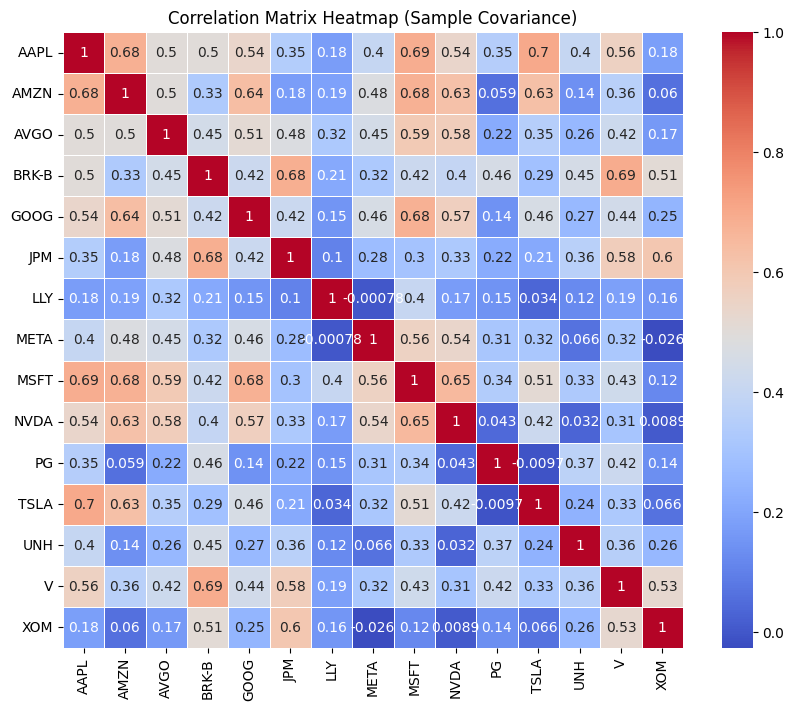

<Figure size 640x480 with 0 Axes>

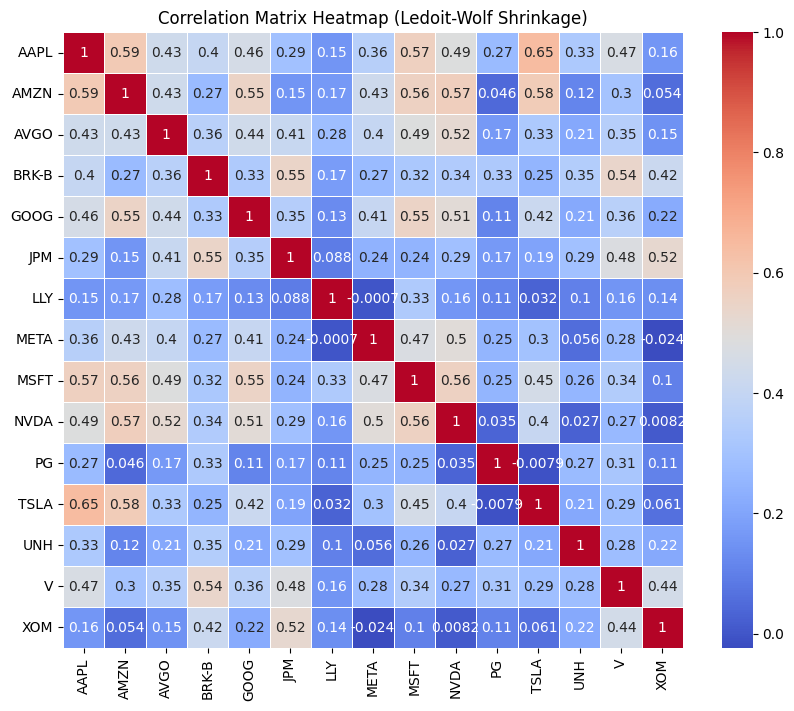

<Figure size 640x480 with 0 Axes>

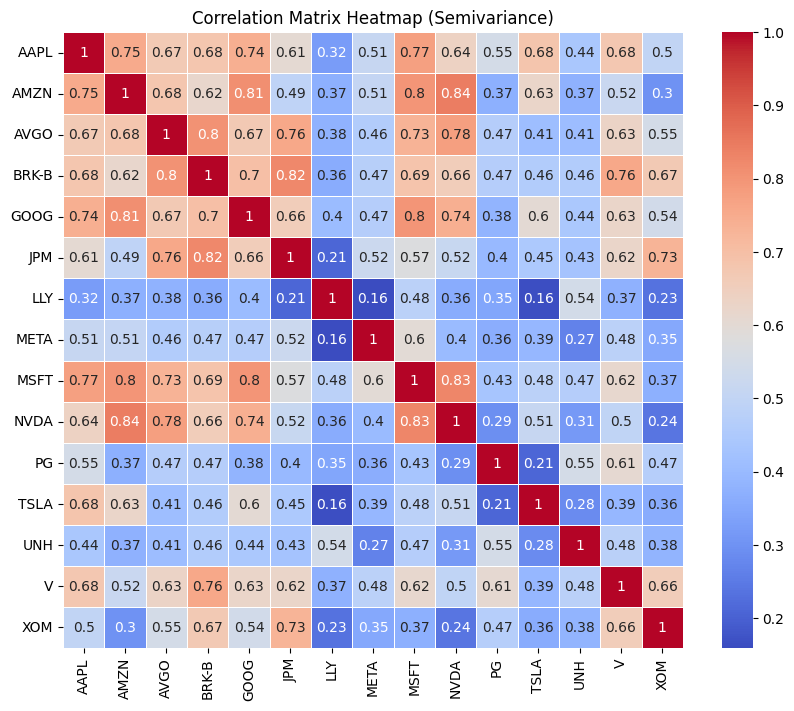

<Figure size 640x480 with 0 Axes>

In [69]:

# required packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from pypfopt import risk_models, expected_returns, EfficientFrontier, EfficientSemivariance, base_optimizer

# Load prices
prices = pd.read_csv('combined_eod_data_tiingo.csv')
prices.set_index('date', inplace=True)
prices.index = pd.to_datetime(prices.index)

# Calculate monthly prices and returns
monthly_prices = prices.resample('ME').last()  # Resample to get monthly prices
monthly_returns = monthly_prices.pct_change().dropna()
mu_monthly = expected_returns.mean_historical_return(monthly_prices, frequency=12)
# print(mu_monthly)

# Calculate covariance matrices
cov_pfopt = risk_models.sample_cov(monthly_prices, frequency=12) # inclusion in output only. Easy to understand method
cov_ledoit = risk_models.CovarianceShrinkage(monthly_prices, frequency=12).ledoit_wolf()
semivarcov = risk_models.semicovariance(monthly_prices, benchmark=0.0, frequency=12)

# Convert covariance matrices to correlation matrices
def calculate_correlation(cov_matrix):
    variances = np.diag(cov_matrix) 
    std_dev = np.sqrt(variances)
    sd_df = pd.Series(std_dev, index=cov_matrix.index)

    # Divide by sd. to get correlation
    corr_matrix = cov_matrix.divide(sd_df, axis=0)  
    corr_matrix = corr_matrix.divide(sd_df, axis=1)

    return corr_matrix

# Calculate correlation matrices
corr_cov_pfopt = calculate_correlation(cov_pfopt)
corr_cov_ledoit = calculate_correlation(cov_ledoit)
cor_semicov = calculate_correlation(semivarcov)

# Plotting the correlation matrices as heatmaps
plt.figure(figsize=(10, 8))
sns.heatmap(corr_cov_pfopt, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap (Sample Covariance)')
plt.show()
plt.savefig('correlation_heatmap.png')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_cov_ledoit, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap (Ledoit-Wolf Shrinkage)')
plt.show()
plt.savefig('correlation_heatmap_ledoit.png')

plt.figure(figsize=(10, 8))
sns.heatmap(cor_semicov, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap (Semivariance)')
plt.show()
plt.savefig('correlation_heatmap_semivar.png')


In [ ]:
'''
Optimisations
'''
from pypfopt import risk_models, expected_returns, EfficientFrontier, EfficientSemivariance, base_optimizer

# Other variables
annual_risk_free = 0.02 # standard default. Is this ok, or should it be adjusted? 
inflation_plus = 0.09 # TODO: pull CPI data for the input period and get annual number. CPI+5% (real return equity target)
assets = len(monthly_prices.columns)
max_weight = (1 / assets) * 2


# Equal Weighted Portfolio
ew = np.array([1/assets] * assets)
stock_ew = round(1 / assets, 5)
equal_weight_dict = {ticker: stock_ew for ticker in monthly_prices.columns}
ef_ew = EfficientFrontier(mu_monthly,cov_ledoit)
ef_ew.set_weights(equal_weight_dict)
print(f"Equal Weighted Portfolio:")
print(equal_weight_dict)
ef_ew.portfolio_performance(verbose=True, risk_free_rate=annual_risk_free)


# Max Sharpe Ratio Portfolio
ef_sharpe = EfficientFrontier(mu_monthly, cov_ledoit, weight_bounds=(0.01, max_weight))
ef_sharpe.max_sharpe(risk_free_rate=annual_risk_free)
max_sharpe_weights_monthly = ef_sharpe.clean_weights()
max_sharpe_weights_monthly = {ticker: round(weight, 5) for ticker, weight in max_sharpe_weights_monthly.items()}
print(f"Max Sharpe Portfolio:")
print(max_sharpe_weights_monthly)
max_sharpe_performance_monthly = ef_sharpe.portfolio_performance(verbose=True, risk_free_rate=annual_risk_free)


# Efficient Return - 'Markovitz portfolio'
ef_markowitz = EfficientFrontier(mu_monthly, cov_ledoit, weight_bounds=(0.01, max_weight))
ef_markowitz.efficient_return(target_return=inflation_plus)
max_ef_markowitz_weights_monthly = ef_markowitz.clean_weights()
max_ef_markowitz_weights_monthly = {ticker: round(weight, 5) for ticker, weight in max_ef_markowitz_weights_monthly.items()}
print(f"Markowitz Portfolio:")
print(max_ef_markowitz_weights_monthly)
max_sharpe_performance_monthly = ef_markowitz.portfolio_performance(verbose=True, risk_free_rate=annual_risk_free)


# Minimum Volatility Portfolio
ef_monthly = EfficientFrontier(mu_monthly, cov_ledoit, weight_bounds=(0.01, max_weight))
ef_monthly.min_volatility()
min_vol_weights_monthly = ef_monthly.clean_weights()
min_vol_weights_monthly = {ticker: round(weight, 5) for ticker, weight in min_vol_weights_monthly.items()}
print(f"Minimum Vol Portfolio:")
print(min_vol_weights_monthly)
min_vol_performance_monthly = ef_monthly.portfolio_performance(verbose=True,risk_free_rate=annual_risk_free)


# Semivariance - Minimise Semivariance
svo_historic_returns = expected_returns.returns_from_prices(monthly_prices)
svo = EfficientSemivariance(mu_monthly, svo_historic_returns, frequency=12, weight_bounds=(0.01, max_weight))
svo.min_semivariance()
svoweights = svo.clean_weights()
# print(svoweights)
svo.portfolio_performance(verbose=True,risk_free_rate=annual_risk_free)

#TODO - this method doesn't work. 
''' 
# PMPT - Optimise for Sortino Ratio
# Heuristic method - suggested at https://github.com/robertmartin8/PyPortfolioOpt/issues/401
semivarcov = risk_models.semicovariance(monthly_prices, benchmark=0, frequency=12)
PMPT = ef_monthly = EfficientFrontier(mu_monthly, semivarcov, weight_bounds=(0.01, max_weight))
PMPT.efficient_return(inflation_plus)
# PMPT.max_sharpe(risk_free_rate=monthly_risk_free)
PMPT_weights = PMPT.clean_weights()
# print(PMPT_weights)
svo.set_weights(PMPT_weights) # 'hack' to generate sortino. 
PMPT_performance = svo.portfolio_performance(verbose=True,risk_free_rate=monthly_risk_free)
'''


# Combine to dataframe
ew_series = pd.Series(equal_weight_dict, name='Equal Weights (%)')
max_sharpe_series = pd.Series(max_sharpe_weights_monthly, name='Max Sharpe Weights (%)')
markowitz_series = pd.Series(max_ef_markowitz_weights_monthly, name='Markowitz Weights (%)')
min_vol_series = pd.Series(min_vol_weights_monthly, name='Min Vol Weights (%)')
svo_series = pd.Series(svoweights, name="Min Semivariance (%)")
weights_df = pd.concat([ew_series, max_sharpe_series, markowitz_series, min_vol_series, svo_series], axis=1)
print(weights_df)

Equal Weighted Portfolio:
{'AAPL': 0.06667, 'AMZN': 0.06667, 'AVGO': 0.06667, 'BRK-B': 0.06667, 'GOOG': 0.06667, 'JPM': 0.06667, 'LLY': 0.06667, 'META': 0.06667, 'MSFT': 0.06667, 'NVDA': 0.06667, 'PG': 0.06667, 'TSLA': 0.06667, 'UNH': 0.06667, 'V': 0.06667, 'XOM': 0.06667}
Expected annual return: 32.7%
Annual volatility: 19.4%
Sharpe Ratio: 1.58
Max Sharpe Portfolio:
{'AAPL': 0.04286, 'AMZN': 0.01, 'AVGO': 0.13333, 'BRK-B': 0.02558, 'GOOG': 0.01, 'JPM': 0.01, 'LLY': 0.13333, 'META': 0.01, 'MSFT': 0.0736, 'NVDA': 0.13333, 'PG': 0.13333, 'TSLA': 0.03895, 'UNH': 0.13333, 'V': 0.01, 'XOM': 0.10234}
Expected annual return: 40.0%
Annual volatility: 18.1%
Sharpe Ratio: 2.11
Markowitz Portfolio:
{'AAPL': 0.01, 'AMZN': 0.02975, 'AVGO': 0.01, 'BRK-B': 0.13333, 'GOOG': 0.06506, 'JPM': 0.05182, 'LLY': 0.13333, 'META': 0.01406, 'MSFT': 0.12412, 'NVDA': 0.01, 'PG': 0.13333, 'TSLA': 0.01, 'UNH': 0.13333, 'V': 0.07609, 'XOM': 0.06577}
Expected annual return: 24.7%
Annual volatility: 15.1%
Sharpe Ratio